In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet )


# Load Training data

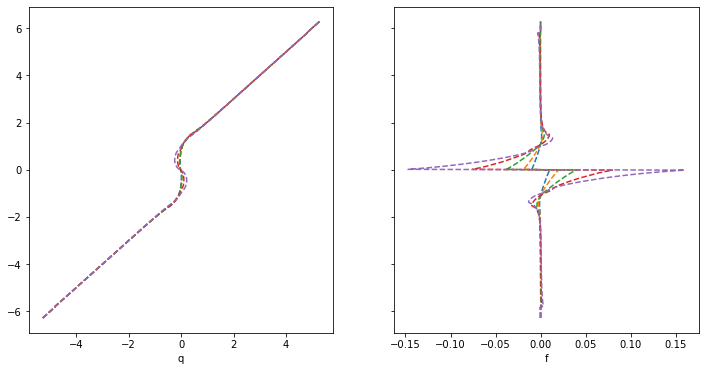

In [5]:
Nx = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)

data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

L = 4*np.pi
xx, closure_mean,  q_mean, dq_dx_mean = np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dx_mean[i, :] = load_data(data_dirs[i])
    xx[i, :] = np.linspace(-L/2.0, L/2.0, Nx)
dx = xx[0, 1] - xx[0, 0]


# TODO: clean data
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
q_jet = omega_jet + beta*xx[0, :]


f = np.zeros(q_mean.shape)
chop_l = 15
for i in range(N_data):  
    q_mean[i, 0:chop_l] = q_jet[0:chop_l]
    q_mean[i, -chop_l:] = q_jet[-chop_l:]
    
    f[i, :] = tau_inv[i]*(q_jet - q_mean[i, :])


# visualize data

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,6))
for i in range(N_data):
    ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("q")
ax[1].set_xlabel("f")   
plt.show()



# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [6]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    

    net =  create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    
    nn_model = partial(nn_flux, net)
    
    for i in range(N_data):
        nummodel(nn_model, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))


## Start UKI

In [7]:
class PoissonParam:
    def __init__(self, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer, aug=True):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta if aug else N_y

In [ ]:
aug = True

y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(N_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
ind, outd, width = 2, 1, 10
layers = 2
activation, initializer, outputlayer = "sigmoid", "default", "None"

s_param = PoissonParam(xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer, aug)


N_theta = s_param.N_theta

theta0_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 10.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)
print(" N_theta = ", s_param.N_theta, " N_y = ", s_param.N_y)
print(" q = ", s_param.q.shape)


alpha_reg = 1.0
update_freq = 1
N_iter = 100
gamma = 1.0

if aug:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
        theta0_mean, theta0_init, theta0_cov,
        y_aug, Sigma_eta_aug,
        alpha_reg,
        gamma,
        update_freq, 
        N_iter)
else:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss, 
        theta0_mean, theta0_init, theta0_cov,
        y, Sigma_eta,
        alpha_reg,
        gamma,
        update_freq,
        N_iter)

trained_net = creat_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])

 N_theta =  41  N_y =  1951
 q =  (5, 384)
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  0 1
optimization error at iter  0  =  4.835245171915841e+18
len(ukiobj.theta_cov) :  0 2
Frobenius norm of the covariance at iter  0  =  640.3124237432849
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  1 2
optimization error at iter  1  =  3.285204096315009e+18
len(ukiobj.theta_cov) :  1 3
Frobenius norm of the covariance at iter  1  =  378.7910359854935
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  2 3
optimization error at iter  2  =  27768592985145.75
len(ukiobj.theta_cov) :  2 4
Frobenius norm of the covariance at iter  2  =  1.6798491914051435e-06
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  3 4
optimization error at iter  3  =  14434899427704.13
len(ukiobj.theta_cov) :  3 5
Frobenius norm of the covariance at iter  3  =  3.6404236819436163e-10


In [ ]:
print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

# Direct test

In [ ]:
# N_test_1d = 200
# L_test_1d = 1.0
# N_test = N_test_1d**2

# x1_test_1d = np.linspace(0, L_test_1d, N_test_1d)
# x2_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
# X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)

# x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
# y_test = permeability_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))


# y_pred = nn_model(x_test, trained_net)  

# y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
# y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

# plt.figure()
# plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
# plt.colorbar()

# plt.figure()
# plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
# plt.colorbar()

# plt.figure()
# plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
# plt.colorbar()


# Plug-in test

In [ ]:
beta = 1.0
N_y = 384
omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
q_jet = omega_jet + beta*yy


tau_inv = "0.08"                                                                                                               
tau = 1/float(tau_inv)
data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

_, Ny, Nt = q.shape
q_mean = np.mean(q[0, :, Nt//2:], axis=1)
w_mean = np.mean(w[0, :, Nt//2:], axis=1)



nn_model = partial(nn_flux, trained_net)

model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
dt, Nt, save_every = 1.0e-4, 200000, 1000
yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = 4*np.pi)
q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(w_mean, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
plt.show()